# Machine Learning Engineer Nanodegree

## Machine Learning Capstone project 

## Project: White Blood Cells segmentation

As part of Udacity machine learning engineer nanodegree capstone project, I am developing a deep learning model using convolutional neural networks for white blood cells segmentation from a given blood sample image


## Problem Description
White blood cells (also known as WBC or leukocytes) help our body fight infections by attacking bacteria, viruses and other germs that invade the body. A count of leukocytes can help reveal several hidden and undiagnosed diseases. In a manual microscopic review of blood samples, pathologists minutely examine the count and morphology (i.e. size and shape) of white blood cells.

Red blood cells (or RBC, or erythrocytes) are the most common type of blood cells, and they outnumber WBCs by about 600:1. So, in an image of a blood sample, you will see mostly RBCs, with a few WBCs thrown in here and there.

![White Blood Cells in Microscope](images/wbc_cells.jpg)

In manual process pathologists analyze the blood sample and count the WBC (white blood cells), but this is not accurately defined the correct count and related disease, they use pre-defined approach to determine the health of the person. But if we use Image segmentation using deep learning supervised algorithm model, it accurately demarcates the boundary of WBC even when they are touching each other and identify correct count. This will improve the accuracy and speed of testing and yield better results.

I hope by using state of the art deep learning model for this image segmentation task will improve the accuracy of results and correctly identify the health of a person.

I am developing an efficient Deep Learning model using CNN (Convolutional Neural Networks) to accurately demarcate the boundary of white blood cells in microscopic images of blood.


## Datasets and Inputs

The dataset for this project originates from the [SigTuple AI Challenge](https://www.hackerearth.com/challenge/competitive/sigtuple-ai-challenge/). SigTuple released this data set to hire top AI talent for their engineering team. The data set is available at the [hackathon](https://s3-ap-southeast-1.amazonaws.com/he-public-data/contests/SigTuple_data.tar) competition.

I thought this is a good research problem and have a scope to select as a capstone for Machine Learning Nano degree.

## Exploring the Data
The training set consists of 164 (128X128) patches showing WBCs, and the area has been demarcated in a mask file. The cell at the center of these patches are WBCs, while those surrounding the WBC are RBCs. The files are named like train-0.jpg, train-1.jpg, .... 

The corresponding mask files are named train-0-mask.jpg, train-1-mask.jpg, ..., respectively. There are also around 5 larger images (and corresponding masks) of blood, showing one or more WBCs in the image.
The test set will consist of larger images of blood smears, from which we need to demarcate the WBC boundaries

In [16]:
# import train and test data paths from params
%matplotlib inline
import os
import cv2
import matplotlib.pyplot as plt
from all_params import TRAIN_DATA_PATH, TEST_DATA_PATH

images_train = os.listdir(TRAIN_DATA_PATH)
images_test = os.listdir(TEST_DATA_PATH)

# print number of train and test images
print 'number of train images: ', len(images_train)/2
print 'number of train_mask images: ', len(images_train)/2
print 'number of test images: ', len(images_test)

number of train images:  169
number of train_mask images:  169
number of test images:  61


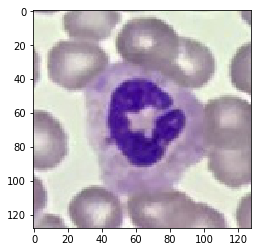

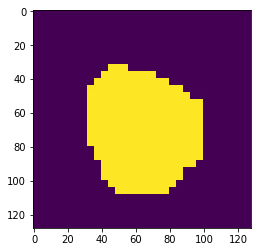

In [36]:
from skimage import io
import matplotlib.pyplot as plt

# showing train and mask images from Train_Data
image1 = io.imread('SigTuple_data/Train_Data/train-0.jpg')
image2 = io.imread('SigTuple_data/Train_Data/train-0-mask.jpg')

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

# Preparing the data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid data we must deal with, however, there are 5 large images (corresponding masks) of blood. So we need to re-size these images to 128 * 128 without lossing the pixel information from both train and mask data and store it in new folder called new_train_data. So that all the images(both train and mask) are in same dimension and pass to our deep learning algorithm for trianing.

In [17]:
import os
import cv2
import numpy as np
from all_params import *

image_names = os.listdir(TRAIN_DATA_PATH)
image_names.sort()

img_num = IMG_START_NUM
print('-'*30)
print('Creating new training images and store them in new_train_data_path...')
print('-'*30)
for img_name in image_names:
    if 'mask' in img_name:
        continue

    img = cv2.imread(TRAIN_DATA_PATH + img_name)
    mask_img = cv2.imread(TRAIN_DATA_PATH + img_name.split('.')[0] + '-mask.jpg')
    if img.shape == (IMG_ROWS, IMG_COLS, 3):
        cv2.imwrite(NEW_TRAIN_DATA_PATH + img_name, img)
        cv2.imwrite(NEW_TRAIN_DATA_PATH + img_name.split('.')[0] + '-mask.jpg', mask_img)
        continue
    if CREATE_EXTRA_DATA == False:
        continue

    for row in range(0, img.shape[0], IMG_ROWS):
        for col in range(0, img.shape[1], IMG_COLS):
            new_img = img[row:row + IMG_ROWS, col:col + IMG_COLS, :]
            new_mask_img = mask_img[row:row + IMG_ROWS, col:col + IMG_COLS, :]
            if new_img.shape != (IMG_ROWS, IMG_COLS, 3) or np.max(new_mask_img) != 255.0:
                continue
            cv2.imwrite(NEW_TRAIN_DATA_PATH + 'train-' + str(img_num) + '.jpg', new_img)
            cv2.imwrite(NEW_TRAIN_DATA_PATH + 'train-' + str(img_num) + '-mask.jpg', new_mask_img)
            img_num = img_num + 1
print('successfully created.')

------------------------------
Creating new training images and store them in new_train_data_path...
------------------------------
successfully created.


## Create train and test data sets
From the given training data set(SigTuple_data/Train_Data) the train images(train-0.jpg, train-1.jpg, train-2.jpg.. etc) can act as a training set and mask images(train-0-mask.jpg, train-1-mask.jpg, train-2-mask.jpg.. etc) as dependent to fit to our train images. We can create these two sets as X_train and Y_train and pass these for training to our model. Here we are using tensorflow as a back end for our keras deep learning model.

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape
    $$
    (\\{nb_samples}, \\{rows}, \\{columns}, \\{channels})
    $$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively. 

In [20]:
import os
import cv2
import numpy as np
from all_params import * 

path=NEW_TRAIN_DATA_PATH
augment=AUGMENT_TRAIN_DATA
image_names = os.listdir(path)
image_names.sort()
images_count = len(image_names) / 2

if augment == True:
    images_count = images_count * 3
X_train = np.ndarray((images_count, 1, IMG_ROWS, IMG_COLS), dtype=np.uint8)
Y_train = np.ndarray((images_count, 1, IMG_ROWS, IMG_COLS), dtype=np.uint8)

i = 0
print('-'*30)
print('Creating training images...')
print('-'*30)
for img_name in image_names:
    if 'mask' in img_name:
        continue
    mask_img_name = img_name.split('.')[0] + '-mask.jpg'
    img = cv2.imread(path + img_name, cv2.IMREAD_GRAYSCALE)
    img[img <= CLEAN_THRESH] = 255
    mask_img = cv2.imread(path + mask_img_name, cv2.IMREAD_GRAYSCALE)
    X_train[i] = np.array([img])
    Y_train[i] = np.array([mask_img])
    i = i + 1

    if augment == True:
        X_train[i] = np.array([img[:, ::-1]])
        Y_train[i] = np.array([mask_img[:, ::-1]])
        i = i + 1
        X_train[i] = np.array([img[::-1, :]])
        Y_train[i] = np.array([mask_img[::-1, :]])
        i = i + 1
print('Loading done.')
X_train = X_train.transpose((0, 2, 3, 1))
Y_train = Y_train.transpose((0, 2, 3, 1))


------------------------------
Creating training images...
------------------------------
Loading done.


## Create a CNN (Convolutional Neural Networks) model to accurately demarcate the boundary of white blood cells in microscopic images of blood
For this problem who need to apply Instance based segmentation approach also called simultaneous detection and segmentation. If you use normal convolution approach we need more processing and training time for object detection and a separate method to segment each instance but if you use modified [U-net model](https://arxiv.org/abs/1505.04597), you can run your input end to end at a time and there is no separate processing for identification and segmentation of instances.

The model consists of a contracting path (left side) and an expansive path (right side). 
The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for down sampling. At each down sampling step, we double the number of feature channels. 
Every step in the expansive path consists of an up sampling of the feature map followed by a 2x2 convolution (\up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. 

Most of the time dropout is applied to fully connected layers compared to convolutional layers. since the convolutional layers don’t have a lot of parameters, overfitting is not a problem and therefore dropout would not have much effect. However, the additional gain in performance obtained by adding dropout in the convolutional layers (3.02% to 2.55%) is worth noting. Dropout in the lower layers still helps because it provides noisy inputs for the higher fully connected layers which prevents them from overfitting.

In [21]:
from model import get_model
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inputs (InputLayer)              (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 128, 128, 32)  320         inputs[0][0]                     
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 128, 128, 32)  9248        conv1_1[0][0]                    
____________________________________________________________________________________________________
pool_1 (MaxPooling2D)            (None, 64, 64, 32)    0           conv1_2[0][0]                    
___________________________________________________________________________________________

## Evaluation Metrics
We use Dice coefficient or F1 score for evaluation of the model on predicted masks with ground truth values.

The Dice score is often used to quantify the performance of image segmentation methods. There you annotate some ground truth region in your image and then make an automated algorithm to do it. You validate the algorithm by calculating the Dice score, which is a measure of how similar the objects are. So it is the size of the overlap of the two segmentations divided by the total size of the two objects. Using the same terms as describing accuracy, the Dice score is:

Dice score=number of true positives/number of positives + number of false positives

So the number of true positives, is the number that your method finds, the number of positives is the total number of positives that can be found and the number of false positives is the number of points that are negative that your method classifies as positive.


In [22]:
import numpy as np
from keras import backend as K
from all_params import SMOOTH

def dice_coef(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + SMOOTH) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + SMOOTH)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def np_dice_coef(y_true, y_pred):
    y_true_flat = y_true.flat[:]
    y_pred_flat = y_pred.flat[:]
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + SMOOTH) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + SMOOTH)

def np_dice_coef_loss(y_true, y_pred):
    return 1.0 - np_dice_coef(y_true, y_pred)

## Train the model
Train the model on X_train, Y_train data. We can create a separate folder checkpoints for best echo weights files. Finally the best model can be saved in WEIGHTS path file.

In [24]:
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from model import get_model
from all_params import *

X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')
X_train /= 255.0
Y_train /= 255.0

model = get_model()
model.summary()
model.compile(optimizer=Adam(lr=BASE_LR), loss=dice_coef_loss, metrics=[dice_coef])
callbacks = [ModelCheckpoint(MODEL_CHECKPOINT_DIR + '{epoch:02d}_{loss:.06f}.hdf5', monitor='loss', save_best_only=True),
             ReduceLROnPlateau(monitor='loss', factor=0.1, patience=PATIENCE, min_lr=1e-07, verbose=1)]
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)
model.save_weights(WEIGHTS)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inputs (InputLayer)              (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 128, 128, 32)  320         inputs[0][0]                     
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 128, 128, 32)  9248        conv1_1[0][0]                    
____________________________________________________________________________________________________
pool_1 (MaxPooling2D)            (None, 64, 64, 32)    0           conv1_2[0][0]                    
___________________________________________________________________________________________

Epoch 1/50
182/182 [==============================] - 6s - loss: 0.3518 - dice_coef: 0.6482     
Epoch 2/50
182/182 [==============================] - 5s - loss: 0.1846 - dice_coef: 0.8154     
Epoch 3/50
182/182 [==============================] - 5s - loss: 0.1585 - dice_coef: 0.8415     
Epoch 4/50
182/182 [==============================] - 5s - loss: 0.1423 - dice_coef: 0.8577     
Epoch 5/50
182/182 [==============================] - 5s - loss: 0.1362 - dice_coef: 0.8638     
Epoch 6/50
182/182 [==============================] - 5s - loss: 0.1329 - dice_coef: 0.8671     
Epoch 7/50
182/182 [==============================] - 5s - loss: 0.1289 - dice_coef: 0.8711     
Epoch 8/50
182/182 [==============================] - 5s - loss: 0.1187 - dice_coef: 0.8813     
Epoch 9/50
182/182 [==============================] - 5s - loss: 0.1149 - dice_coef: 0.8851     
Epoch 10/50
182/182 [==============================] - 5s - loss: 0.1150 - dice_coef: 0.8850     
Epoch 11/50
182/182 [========

## Submission Data
Now we have a model in place and trianed on given train and mask images and predicted with 94% accuracy. Now we have to generate masks from given test data

In [25]:
import os
import cv2
import numpy as np
from model import get_model
from skimage.measure import label
from skimage.measure import regionprops
from all_params import *

image_names = os.listdir(TEST_DATA_PATH)
image_names.sort()
model = get_model(train=False)
model.load_weights(WEIGHTS)

for img_name in image_names:
    mask_img_name = img_name.split('.')[0] + '-mask.jpg'
    img = cv2.imread(TEST_DATA_PATH + img_name, cv2.IMREAD_GRAYSCALE)
    img[img <= CLEAN_THRESH] = 255
    mask_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    ret, thresh_img = cv2.threshold(img, THRESH, 255, cv2.THRESH_BINARY_INV)
    img_label = label(thresh_img)
    for region in regionprops(img_label):
        minr, minc, maxr, maxc = region.bbox
        if region.area < 500:
            continue
        r, c = (minr + maxr - IMG_ROWS) / 2, (minc + maxc - IMG_COLS) / 2
        if r < 0:
            r = 0
        if c < 0:
            c = 0
        if r + IMG_ROWS > img.shape[0]:
            r = img.shape[0] - IMG_ROWS
        if c + IMG_COLS > img.shape[1]:
            c = img.shape[1] - IMG_COLS
        test_img = img[r:r + IMG_ROWS, c:c + IMG_COLS]
        if test_img.shape != (IMG_ROWS, IMG_COLS):
            continue

        test_img = np.array([[test_img]], dtype=np.float32)
        test_img /= 255.0
        test_mask_img = model.predict(test_img.transpose(0, 2, 3, 1), verbose=1)
        test_mask_img = (test_mask_img * 255.0).astype(np.uint8)
        test_mask_img = test_mask_img.transpose(0, 3, 1, 2)[0][0]
        
        mask_img[r:r + IMG_ROWS, c:c + IMG_COLS] = test_mask_img
        cv2.imwrite(SUBMISSION_DATA_PATH + mask_img_name, mask_img)


1/1 [==============================] - 0s


## Validation of the model

We need to validate our model using dice_coefficient metrics against benchmark model. 

The original U-net model have achieved 77.5% accuracy on DIC-HeLa data set from ISBI cell tracking challenge. I am taking this is as a benchmark and try to achieve more accuracy with modified U-net architecture.

In [28]:
from model import get_model
from all_params import WEIGHTS

model = get_model(train=False)
model.summary()
model.load_weights(WEIGHTS)
Y_preds = model.predict(X_train, batch_size=3, verbose=1)
print "\n{:.06f}".format(np_dice_coef(Y_train, Y_preds))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
inputs (InputLayer)              (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 128, 128, 32)  320         inputs[0][0]                     
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 128, 128, 32)  9248        conv1_1[0][0]                    
____________________________________________________________________________________________________
pool_1 (MaxPooling2D)            (None, 64, 64, 32)    0           conv1_2[0][0]                    
___________________________________________________________________________________________

The model have achieved 94% accuracy compared to the bench mark model 77.5%. This model can be effectively used in medical image segmentation tasks and identifying white blood cells from the given blood images. And I hope this model can be used other tasks such as cancer cells identification and segmentation in human body.

The predicted masks for the given test data (SigTuple_data/Test_Data) can be found in Submission_Data (SigTuple_data/Submission_Data) folder. 

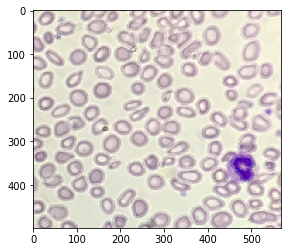

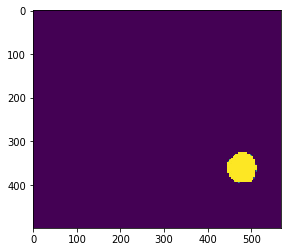

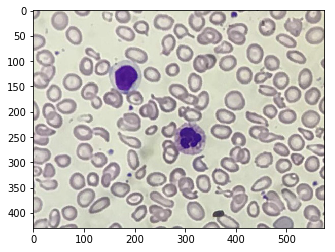

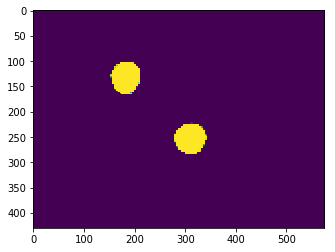

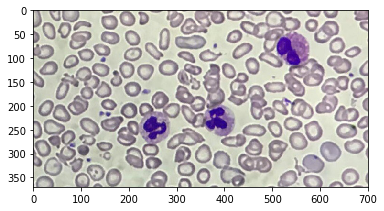

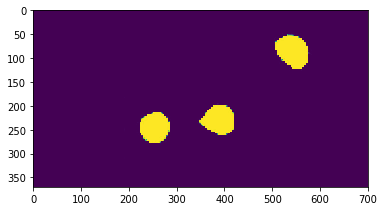

In [40]:
from skimage import io
import matplotlib.pyplot as plt

# showing test and predicted images from Test_Data and Submission_Data
image1_test = io.imread('SigTuple_data/Test_Data/F1BFEA74B33D.jpg')
image1_predicted_mask = io.imread('SigTuple_data/Submission_Data/F1BFEA74B33D-mask.jpg')
image2_test = io.imread('SigTuple_data/Test_Data/D28CDF85BDA3.jpg')
image2_predicted_mask = io.imread('SigTuple_data/Submission_Data/D28CDF85BDA3-mask.jpg')
image3_test = io.imread('SigTuple_data/Test_Data/D0F6DE661D63.jpg')
image3_predicted_mask = io.imread('SigTuple_data/Submission_Data/D0F6DE661D63-mask.jpg')

plt.imshow(image1_test)
plt.show()
plt.imshow(image1_predicted_mask)
plt.show()
plt.imshow(image2_test)
plt.show()
plt.imshow(image2_predicted_mask)
plt.show()
plt.imshow(image3_test)
plt.show()
plt.imshow(image3_predicted_mask)
plt.show()
